In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
import rdflib
from lxml import etree
import pandas
import re
import xml.etree.ElementTree as ET
import os

# c) General
import copy
import difflib
import numpy as np

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams

In [2]:
# Ontologies:
# Save the .csv files of each ontology from https://bioportal.bioontology.org/ontologies
FMA = pandas.read_csv('FMA.csv')
CHEBI = pandas.read_csv('CHEBI.csv')
OPB = pandas.read_csv('OPB.csv')
GO = pandas.read_csv('GO.csv')

# Extraction of IDs & Labels in the ontologies

fmaID = FMA['Class ID']
fmaLabel= FMA['Preferred Label']
chebiID = CHEBI['Class ID']
chebiLabel= CHEBI['Preferred Label']
opbID = OPB['Class ID']
opbLabel= OPB['Preferred Label']
goID = GO['Class ID']
goLabel= GO['Preferred Label']

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (41,71,75,77,99,100,103,113,114,138,140,156,157,158,178,198) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11,12,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
categories=[['m'],['m'],['m'],['m'],['m']];
addresses=['/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L1.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L2.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L3.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L4.cellml',
           '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/MAPK cascade/MAPK_L5.cellml']

In [4]:
## Extracting the data (annotations & values) from the CellML files

#  Input(s):    add: The list of locations (addresses) which is the output from the "catRecognition" function

#  Output(s):   a) List: a dictionary containing the names of the variables in the CellML files (in the order of the 
#                        found annotations)
#               b) annotations: a dictionary containing the annotations in the CellML files
#               c) root: a dictionary containing the imported XML data from the CellML files

def getAnnotations(add):
    parser = etree.XMLParser(recover=True)
    root = etree.parse(add, parser).getroot()
    rdfGraph = rdflib.Graph()
    for rdfElement in root.iter():
        if rdfElement.tag.endswith('RDF'):
            try:
                rdfGraph.parse(data = etree.tostring(rdfElement))
            except:
                pass
            
    def getLeaves(sbj, graph):
        triples = list(graph.triples((sbj,None,None)))
        leaves = []
        if len(triples)>0:
            for s, p, o in triples:
                result =  getLeaves(o,graph)
                leaves += result
            return list(set(leaves))
        else:
            return [sbj]
        
    # Opens the CellML file and returns the list of variables names
    base=os.path.basename(add)
    f = open(base,'r')
    text = f.read()
    root = ET.fromstring(text)

    rdfs = root.findall('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF')

    List1=[]
    for child in rdfs:
        for grand in child:
            List1.append(grand.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'))
    
    List = list(dict.fromkeys(List1))
    List.remove('#metaid0')


    triplesList={}
    for i in range(len(List)):
        sbj = rdflib.URIRef(List[i])
        triplesList[i]=getLeaves(sbj, rdfGraph)

        # In this part we match the number found in the rdf of the CellML file 
        # with the ones found in the "Class IDs" and "Preferred Labels"

    annotations1={}

    for i in range(len(triplesList)):
        annotations1[i]=[]
        for k in range(len(triplesList[i])):
            l=triplesList[i][k]
            if 'opb' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for OPB
                for j in range(len(opbID)):
                    numID=re.findall(r'\d+', opbID[j])
                    if numCell == numID:
                        annotations1[i].append(opbLabel[j])
            elif 'chebi' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for CHEBI
                for j in range(len(chebiID)):
                    numID=re.findall(r'\d+', chebiID[j])
                    if numCell == numID:
                        annotations1[i].append(chebiLabel[j])
            elif 'fma' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for FMA
                for j in range(len(fmaID)):
                    numID=re.findall(r'\d+', fmaID[j])
                    if numCell == numID:
                        annotations1[i].append(fmaLabel[j])

            elif 'go' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for GO
                for j in range(len(goID)):
                    numID=re.findall(r'\d+', goID[j])
                    if numCell == numID:
                        annotations1[i].append(goLabel[j])

            else: # 'thermodynamic constant' is a free-style description!
                annotations1[i].append(l.lower()) # So we look for it separately.
                
#             elif 'thermodynamic constant' in l.lower(): # 'thermodynamic constant' is a free-style description!
#                 annotations1[i].append('thermodynamic constant') # So we look for it separately.


    for i in range(len(annotations1)):
        annotations1[i]=[x.lower() for x in annotations1[i]] 

    annotations = {}; k=0;

    for key,value in annotations1.items():
        if value not in annotations.values():
            annotations[k] = value
            k+=1

    return [List,annotations,root]

In [5]:
## Extracting values from the CellML files

#  Input(s):  root: a dictionary containing the imported XML data from the output of the "getAnnotations" functions

#  Output(s): els: (representing the elements) a dictionary containing the names of the variables in the CellML files 
#                  (in the order of the  found initial amounts)
#             init: (representing the initials) a dictionary containing the initial amounts of the variables in the 
#                   CellML files 

def valExtraction(root): 
    
    variables=[]; els=[]; init=[];

    components = root.findall('{http://www.cellml.org/cellml/1.1#}component')


    for comp in components:
        variables.append(comp.findall('{http://www.cellml.org/cellml/1.1#}variable'))


    for var in variables:
        for v in var:   #Here search for the variable names(els) and their initial amounts(init)
            els.append(v.attrib['{http://www.cellml.org/metadata/1.0#}id'])   

            if 'initial_value' in v.attrib: # if any initial value exists take it
                init.append(v.attrib['initial_value'])    
            else:
                init.append(None)
    return[els,init]

In [6]:
# In the following script the two above functions (getAnnotations,valExtraction) are used to extract the annotations,
# variable names, and amounts. For instance, all the annotations of all the files will be saved in ONE
# dictionary (annotationsMAPKunsorted) as annotationsMAPKunsorted={'0':{...,...,...}, '1':{...,...,...}, ...}
listMAPK={}; annotationsMAPKunsorted={}; rootMAPK={};
elementsMAPK={}; initialsMAPK={}; 
for i in range(len(categories)):
    if categories[i][0] == 'm':
        [listMAPK[str(i)],annotationsMAPKunsorted[str(i)],rootMAPK[str(i)]]=getAnnotations(addresses[i])        
        [elementsMAPK[str(i)],initialsMAPK[str(i)]]=valExtraction(rootMAPK[str(i)])
                
    else: # For later adding other possible categories
        pass

In [7]:
model=bgt.new(name='MAPK Cascades')

In [8]:
## MAPK loops (cycles) BG model

# Input(s):  Model: The newly defined bond graph model
#            annotations: A dictionary containing the annotations in the CellML files

# Output(s): mapkCascades: The "mapkCascades" dictionary contains the sub-dictionaries in which the annotations 
#                          for each cycle are given as reference
#            connectivityMatrixx: The connectivity matrix (a list) for one MAPK cycle
#            mergeableComponents: List of potential mergeable components along with their corresponding junctions
#            Components: A dictionary containing the generated BG components for each inserted module
#            newAnnot: A dictionary containing the annotations in the CellML files in which the keys are substituted
#                      with the identified cycle numbers as they are defined in the function

def mapkModelMaker(Model,annotations): 

    mapkCascades={'mapk_Dict_1':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase kinase activity'],  # MKKK
            6: ['concentration of chemical', 'activation of mapkkk activity'], # MKKKP
            7: ['concentration of chemical', 'map kinase kinase kinase kinase activity'],  # E1=MKKKK                                 
            8: ['map kinase phosphatase activity', 'concentration of chemical'], # E2=MKKK_Pase
            9: ['concentration of chemical','protein phosphorylation','l1'], # C1
            10: ['concentration of chemical','protein dephosphorylation','l1'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase kinase kinase activity'],  # K_MKKK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_MKKKP
            16: ['map kinase kinase kinase kinase activity','thermodynamic constant','concentration of chemical'], # K_MKKKK      
            17: ['thermodynamic constant','map kinase phosphatase activity', 'concentration of chemical'], # K_MKKK_Pase
            18: ['thermodynamic constant l1','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant l1'], # K_C2
            20: ['reaction rate constant','map kinase kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','activation of mapkkk activity', 'phosphate ion binding','reaction rate constant']}, # r4  


            'mapk_Dict_2':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'map kinase kinase activity'],  # MKK
            6: ['concentration of chemical', 'activation of mapkk activity'], # MKKP
            7: ['concentration of chemical', 'activation of mapkkk activity'], # E1=MKKKP
            8: ['concentration of chemical', 'phosphatase binding'], # E2=MKK_Pase
            9: ['concentration of chemical','protein phosphorylation', 'l2'], # C1
            10: ['concentration of chemical','protein dephosphorylation', 'l2'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase kinase activity'],  # K_MKK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapkk activity'], # K_MKKP
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_E1=K_MKKKP
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase activity'], #K_E2
            18: ['thermodynamic constant l2','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['thermodynamic constant l2','concentration of chemical','protein dephosphorylation'], # K_C2
            20: ['reaction rate constant','map kinase kinase activity','phosphorylation','atp binding'], # r1
            21: ['adp binding','activation of mapkk activity', 'phosphorylation','reaction rate constant'], # r2
            22: ['adp binding', 'activation of mapkk activity', 'dephosphorylation', 'reaction rate constant'], # r3
            23: ['dephosphorylation','map kinase kinase activity', 'phosphate ion binding','reaction rate constant']}, # r4
                 
            'mapk_Dict_3':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P
            5: ['concentration of chemical', 'activation of mapkk activity'],  # MKKP
            6: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # MKKPP
            7: ['concentration of chemical', 'activation of mapkkk activity'],  # E1=MKKKP                    
            8: ['concentration of chemical', 'phosphatase binding'], # E2=MKK_Pase
            9: ['concentration of chemical','protein phosphorylation', 'l3'], # C1
            10: ['concentration of chemical','protein dephosphorylation', 'l3'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'activation of mapkk activity'],  # K_MKKP
            15: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # K_MKKPP
            16: ['thermodynamic constant','concentration of chemical', 'activation of mapkkk activity'], # K_MKKKP (E1)
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase binding'], # K_MKKPase (E2)
            18: ['thermodynamic constant l3','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant l3'], # K_C2
            20: ['phosphorylation','protein phosphorylation','reaction rate constant','atp binding','activation of mapkkk activity'], # r1                      
            21: ['phosphorylation','protein phosphorylation','reaction rate constant','adp binding','mitogen-activated protein kinase kinase binding'],# r2
            22: ['mitogen-activated protein kinase kinase binding','dephosphorylation','protein dephosphorylation','reaction rate constant'], #r3 
            23: ['phosphate ion binding','dephosphorylation','protein dephosphorylation','reaction rate constant','activation of mapkk activity']}, # r4
                 
            'mapk_Dict_4':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P                
            5:  ['concentration of chemical', 'map kinase activity'], # MK
            6: ['concentration of chemical', 'activation of mapk activity'], # MKP
            7: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'],# E1=MKKPP
            8: ['concentration of chemical', 'phosphatase complex'],  # E2=MK_Pase
            9: ['concentration of chemical','protein phosphorylation', 'l4'], # C1
            10: ['concentration of chemical','protein dephosphorylation', 'l4'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'map kinase activity'], # K_MK
            15: ['thermodynamic constant','concentration of chemical', 'activation of mapk activity'],  # K_MKP
            16: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], # K_MKKPP
            17: ['thermodynamic constant','concentration of chemical', 'phosphatase complex'], # K_MK_Pase
            18: ['thermodynamic constant l4','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant l4'], # K_C2
            20: ['phosphorylation','protein phosphorylation','reaction rate constant','atp binding', 'mitogen-activated protein kinase kinase binding'], # r1
            21: ['adp binding','phosphorylation','protein phosphorylation','reaction rate constant', 'activation of mapk activity'], # r2
            22: ['activation of mapk activity','dephosphorylation','protein dephosphorylation','reaction rate constant'], #r3 
            23: ['dephosphorylation','protein dephosphorylation','reaction rate constant','phosphate ion binding','map kinase activity']},# r4
                
            'mapk_Dict_5':{0: ['temperature'], # T 
            1: ['ideal gas constant'], # R                
            2: ['concentration of chemical', 'atp binding'], # ATP
            3: ['concentration of chemical', 'adp binding'], # ADP
            4: ['concentration of chemical', 'phosphate ion binding'], # P 
            5: ['concentration of chemical', 'activation of mapk activity'], # MKP
            6: ['concentration of chemical', 'mitogen-activated protein kinase binding'], # MKPP
            7: ['concentration of chemical', 'mitogen-activated protein kinase kinase binding'], #E1=MKKPP   
            8: ['concentration of chemical',  'phosphatase complex'],  # E2=MK_Pase
            9: ['concentration of chemical','protein phosphorylation', 'l5'], # C1
            10: ['concentration of chemical','protein dephosphorylation', 'l5'], # C2
            11: ['concentration of chemical', 'thermodynamic constant', 'atp binding'], #K_ATP
            12: ['concentration of chemical', 'thermodynamic constant', 'adp binding'], #K_ADP
            13: ['thermodynamic constant', 'concentration of chemical', 'phosphate ion binding'], # K_P
            14: ['thermodynamic constant','concentration of chemical', 'activation of mapk activity'], # MKP
            15: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase binding'], # MKPP               
            16: ['thermodynamic constant','concentration of chemical', 'mitogen-activated protein kinase kinase binding'], #K_E1(MKKPP)   
            17: ['thermodynamic constant','concentration of chemical',  'phosphatase complex'],  # K_E2(MK_Pase)               
            18: ['thermodynamic constant l5','concentration of chemical','protein phosphorylation'], # K_C1
            19: ['concentration of chemical','protein dephosphorylation','thermodynamic constant l5'], # K_C2
            20: ['phosphorylation','reaction rate constant','atp binding','mitogen-activated protein kinase kinase binding'], #r1               
            21: ['phosphorylation','reaction rate constant','adp binding','mitogen-activated protein kinase kinase binding'], #r2               
            22: ['reaction rate constant','dephosphorylation','protein dephosphorylation','mitogen-activated protein kinase binding'], #r3               
            23: ['reaction rate constant','dephosphorylation','phosphate ion binding','activation of mapk activity']}} #r4               
                           
              


    # Counting the number of unique entities in each loop to detect the loop
    # Based on a number of specific entities, the number of the loop in the MAPK cascade is determined
    
    E1={}; E2={}; C1={}; C2={}; M={}; MP={}; ATP={}; ADP={}; P={}; Re1={}; Re2={}; Re3={}; Re4={}; zeroJunctionE1={};
    zeroJunctionE2={}; zeroJunctionC1={}; zeroJunctionC2={}; zeroJunctionM={}; zeroJunctionMP={}; zeroJunctionATP={};
    zeroJunctionADP={}; zeroJunctionP={}; oneJunctionReactantsRe1={}; oneJunctionProductsRe2={}; oneJunctionReactantsRe3={}; 
    oneJunctionProductsRe4={}; 
    
    # Finding the loop which each input file corresponds to:
    Loop={}
    for a in range(len(annotations)):
        MKKKK_found=0; MKKK_found=0; MKKKP_found=0; MKPP_found=0; 
        MKK_found=0; MKKp_found=0; MKKPase_found=0; MKKPP_found=0; MK_found=0; MKP_found=0;
        for aa in range(len(annotations[str(a)])): 
            if 'map kinase kinase kinase kinase activity' in annotations[str(a)][aa]:# MKKKK
                MKKKK_found+=1
            elif 'map kinase kinase kinase activity' in annotations[str(a)][aa]: # MKKK
                MKKK_found+=1
            elif 'activation of mapkkk activity' in annotations[str(a)][aa]: # MKKKP
                MKKKP_found+=1
            elif 'map kinase kinase activity' in annotations[str(a)][aa]: # MKK
                MKK_found+=1
            elif 'activation of mapkk activity' in annotations[str(a)][aa]: # MKKP
                MKKp_found+=1    
            elif 'phosphatase binding' in annotations[str(a)][aa]: # MKK_Pase
                MKKPase_found+=1 
            elif 'mitogen-activated protein kinase kinase binding' in annotations[str(a)][aa]: # MKKPP
                MKKPP_found+=1
            elif 'map kinase activity' in annotations[str(a)][aa]: # MK
                MK_found+=1
            elif 'activation of mapk activity' in annotations[str(a)][aa]: # MKP
                MKP_found+=1
            elif 'mitogen-activated protein kinase binding' in annotations[str(a)][aa]: # MKPP
                MKPP_found+=1
                
        if MKKKK_found != 0 and MKKK_found != 0 : # It's the first loop in the cascade
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_1')); # The index of the file that is the first loop
        elif MKK_found != 0 :
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_2')); # The index of the file that is the second loop
        elif MKKp_found != 0 and MKKPase_found != 0 and MKKPP_found !=0:
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_3')); # The index of the file that is the third loop
        elif MK_found != 0 :
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_4')); # The index of the file that is the fourth loop
        elif MKPP_found != 0 and MKKPP_found != 0 and MKP_found !=0:
            Loop[str(a)]=[]
            Loop[str(a)].append(list(mapkCascades.keys()).index('mapk_Dict_5')); # The index of the file that is the fifth loop
           
                 
    newAnnot={}
    for key,value,loopk,loopv in zip(annotations.keys(),annotations.values(),Loop.keys(),Loop.values()):
        if key==loopk: 
            newAnnot[str(loopv[0])]=copy.deepcopy(value)
            


            
    for a in newAnnot.keys():        
        E1[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][7]), library="BioChem")  
        E2[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][8]), library="BioChem")  
        C1[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][9]), library="BioChem")
        C2[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][10]), library="BioChem")
        M[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][5]), library="BioChem")   
        MP[int(a)] = bgt.new("Ce", name=set(list(mapkCascades.values())[int(a)][6]), library="BioChem")  
        ATP[int(a)] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[int(a)][2]), library="BioChem")
        ADP[int(a)] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[int(a)][3]), library="BioChem")
        P[int(a)] = bgt.new("Ce_S", name=set(list(mapkCascades.values())[int(a)][4]), library="BioChem")

        # Reactions
        Re1[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][20]) , library="BioChem")
        Re2[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][21]) , library="BioChem")
        Re3[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][22]) , library="BioChem")
        Re4[int(a)] = bgt.new("Re" , name=set(list(mapkCascades.values())[int(a)][23]) , library="BioChem")

        # Junctions
        zeroJunctionE1[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][7]))
        zeroJunctionE2[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][8]))
        zeroJunctionC1[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][9]))
        zeroJunctionC2[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][10]))
        zeroJunctionM[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][5]))
        zeroJunctionMP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][6]))
        zeroJunctionATP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][2]))
        zeroJunctionADP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][3]))
        zeroJunctionP[int(a)] = bgt.new("0", name=set(list(mapkCascades.values())[int(a)][4]))
        oneJunctionReactantsRe1[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][20]))
        oneJunctionProductsRe2[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][21]))
        oneJunctionReactantsRe3[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][22]))
        oneJunctionProductsRe4[int(a)] = bgt.new("1", name=set(list(mapkCascades.values())[int(a)][23]))



    
    # Dictionary containing the generated BG components ("Components")
    Components={}; mergeableComponents={}
    for a in newAnnot.keys(): 

        Components[a]={0:E1[int(a)], 1:E2[int(a)], 2:C1[int(a)], 3:C2[int(a)], 4:M[int(a)], 5:MP[int(a)], 
                  6:ATP[int(a)], 7:ADP[int(a)], 8:P[int(a)], 9:Re1[int(a)], 10:Re2[int(a)], 11:Re3[int(a)],
                  12:Re4[int(a)],13:zeroJunctionE1[int(a)],14:zeroJunctionE2[int(a)],15:zeroJunctionC1[int(a)],
                  16:zeroJunctionC2[int(a)],17:zeroJunctionM[int(a)],18:zeroJunctionMP[int(a)],19:zeroJunctionATP[int(a)],
                  20:zeroJunctionADP[int(a)], 21:zeroJunctionP[int(a)],22:oneJunctionReactantsRe1[int(a)],
                  23:oneJunctionProductsRe2[int(a)], 24:oneJunctionReactantsRe3[int(a)], 25:oneJunctionProductsRe4[int(a)]} 
        
        # List of mergeable components along with their corresponding junctions for later merging ("mergeableComponents")
        #For now, C1 & C2 are not considered among mergeable components despite having the same annotations!
        #Maybe later will be added ....
        mergeableComponents[a]={E1[int(a)], E2[int(a)], M[int(a)], MP[int(a)], ATP[int(a)], ADP[int(a)], P[int(a)],
                                zeroJunctionE1[int(a)],zeroJunctionE2[int(a)], zeroJunctionM[int(a)],zeroJunctionMP[int(a)], 
                                zeroJunctionATP[int(a)], zeroJunctionADP[int(a)],zeroJunctionP[int(a)]}  
    
       
        
    # Connectivity Matrix for one cycle
    connectivityMatrix=np.zeros((26,26))
    connectivityMatrix[9][15]=1; connectivityMatrix[10][23]=1; connectivityMatrix[11][16]=1; connectivityMatrix[12][25]=1; 
    connectivityMatrix[13][22]=1; connectivityMatrix[13][0]=1; connectivityMatrix[14][1]=1; connectivityMatrix[14][24]=1; 
    connectivityMatrix[15][2]=1; connectivityMatrix[15][10]=1; connectivityMatrix[16][3]=1; connectivityMatrix[16][12]=1; 
    connectivityMatrix[17][4]=1; connectivityMatrix[17][22]=1; connectivityMatrix[18][5]=1; connectivityMatrix[18][24]=1;
    connectivityMatrix[19][6]=1; connectivityMatrix[19][22]=1; connectivityMatrix[20][7]=1; connectivityMatrix[21][8]=1; 
    connectivityMatrix[22][9]=1; connectivityMatrix[23][13]=1; connectivityMatrix[23][18]=1; connectivityMatrix[23][20]=1;
    connectivityMatrix[24][11]=1; connectivityMatrix[25][14]=1; connectivityMatrix[25][17]=1; connectivityMatrix[25][21]=1; 
    
    
    connectivityMatrixx=[] # Converting the connectivityMatrix from array to list
    for i in range(len(connectivityMatrix)):
        connectivityMatrixx.append(list(connectivityMatrix[i])) # Connectivity Matrix for one module(cycle/loop) of MAPK cascade      

    
            
    return [mapkCascades,connectivityMatrixx,mergeableComponents,Components,newAnnot]

In [9]:
[mapkCascades,cm,mergeableComponents,Components,annotationsMAPK]=mapkModelMaker(model,annotationsMAPKunsorted)

In [10]:
## Checking for similar annotations among the models.
## If the variables with the same annotations have the same values the function ignores them. Otherwise,
## it asks the user to choose just one value for the two same variables.
## If no amount is inserted by the user, the function arbitarary deletes one of them.

#  Input(s): category: A list of the names of the categories which each model corresponds to
#            annotations: A dictionary containing the annotations for each model (keys are the cycle numbers)
#            List: List of variable names corresponding to the annotations in order of the "annotations" dictionary
#            els: a dictionary containing the names of the variables in the CellML files 
#                 (in the order of the  found initial amounts)
#            init: a dictionary containing the initial amounts of the variables in the CellML files 

# ****** annotations & List have the same order of elements ******
# ****** els & init have the same order of elements ******

#  Output(s): commonAnnots: common annotations found among the models. Keys will be the pairs of cycles' numbers (k1,k2)
#             init: The modified dictionary of the initial amounts

def checkMutual(category,annotations,List,els,init,mergeables): 
    
    if len(category)>1: # if more than one reaction is added, there's a probability of mutual annotations
        commonAnnots={}; # common annotations will be saved in pairs of modules (k1,k2)
        CommonAmountsA={};  # First element of the pair (firstModule,secondModule) stored in this dictionary
        CommonAmountsB={};  # Second element of the pair (firstModule,secondModule) stored in this dictionary
        
        modelsNumber = len(annotations)  # The number of the input files (models)
        k=-1; kk=0
        for i,a in zip(range(modelsNumber),annotations.keys()):
            kk+=1; ii=0;
            
            while ii+kk < modelsNumber:  # Finding common anotations between each pair of the modules
                commonAnnots[a,list(annotations.keys())[ii+kk]]=[]
                k+=1
                CommonAmountsA[str(k)]=[]; CommonAmountsB[str(k)]=[]
                for a1 in range(len(list(annotations.values())[i])):
                    for m in range(len(list(list(mergeables.values())[i]))):
                        if set(list(annotations.values())[i][a1])==set(list(list(mergeables.values())[i])[m].name) and list(list(mergeables.values())[i])[m].metamodel != '0':

                            for a2 in range(len(list(annotations.values())[ii+kk])):
                                for mm in range(len(list(list(mergeables.values())[ii+kk]))):
                                    if set(list(annotations.values())[ii+kk][a2])==set(list(list(mergeables.values())[ii+kk])[mm].name) and list(list(mergeables.values())[ii+kk])[mm].metamodel != '0':

                                        if set(list(annotations.values())[i][a1]) == set(list(annotations.values())[ii+kk][a2]) and list(annotations.values())[i][a1] !=[]:
                                            commonAnnots[list(annotations.keys())[i],list(annotations.keys())[ii+kk]].append(list(annotations.values())[i][a1]) 
                                            varIDA=List[str(i)][a1].strip('#')
                                            for e in range(len(els[str(i)])):
                                                if varIDA == els[str(i)][e].strip('#'):

                                                    CommonAmountsA[str(k)].append(init[str(i)][e])

                                            varIDB=List[str(ii+kk)][a2].strip('#')
                                            for e in range(len(els[str(ii+kk)])):
                                                if varIDB == els[str(ii+kk)][e]:
                                                    CommonAmountsB[str(k)].append(init[str(ii+kk)][e])  
                ii+=1
                                           
            
    # Finding the variables with the same annotations and different values & ignoring the ones with same values    
    commonAnnotsDiffVals={}; CommonAmountsAA={}; CommonAmountsBB={};
    for k in range(len(list(commonAnnots.keys()))):
        commonAnnotsDiffVals[list(commonAnnots.keys())[k]]=[]
        CommonAmountsAA[list(commonAnnots.keys())[k]]=[]
        CommonAmountsBB[list(commonAnnots.keys())[k]]=[]
        for v in range(len(list(commonAnnots.values())[k])):
            if list(CommonAmountsA.values())[k][v] != list(CommonAmountsB.values())[k][v]:
                commonAnnotsDiffVals[list(commonAnnots.keys())[k]].append(list(commonAnnots.values())[k][v])
                CommonAmountsAA[list(commonAnnots.keys())[k]].append(list(CommonAmountsA.values())[k][v])
                CommonAmountsBB[list(commonAnnots.keys())[k]].append(list(CommonAmountsB.values())[k][v])
                                  
    
    # Getting the preferred value from the user for the recognised same variables with different values
    for i in range(len(list(commonAnnotsDiffVals.keys()))):
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):
            print('Different values found for: ')
            print('\n')
            print(list(commonAnnotsDiffVals.values())[i][j] ,list(commonAnnotsDiffVals.keys())[i],':',list(CommonAmountsAA.values())[i][j],  'and' , list(CommonAmountsBB.values())[i][j])   
            list(CommonAmountsAA.values())[i][j]=copy.deepcopy(input('Enter the preferred value:'))
               
                
    # Copying the changed values to the list of initial amounts of the model    
    for i in range(len(list(commonAnnotsDiffVals.keys()))): # number of pairs of models 
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):   
            for n,k in zip(range(len(annotations)),annotations.keys()): 
                for f in range(len(list(annotations[k].values()))):
                    if set(list(commonAnnotsDiffVals.values())[i][j]) == set(list(annotations[k].values())[f]):
                        varID=List[str(n)][f].strip('#')
                        for r in range(len(els[str(n)])):
                            if varID == els[str(n)][r].strip('#'): # Assigning the new values to the old ones in all the models
                                init[str(n)][r]=copy.deepcopy( list(CommonAmountsAA.values())[i][j]) 

                        
                  
    return[commonAnnots, init]

In [11]:
[commonAnnots,initialsMAPK]=checkMutual(categories,annotationsMAPK,listMAPK,elementsMAPK,initialsMAPK,mergeableComponents)        

In [12]:
## Deleting the extra components which have similar annotations along with the cycle number that they belong to. 
## By having the cycle numbers here, we exactly know which component is deleted from which model
## We need to delete (n-1) of each (n) same components throughout the models

# Input(s): commonAnnots: A list of common annotations found among the models.
#           mergeableComponents: List of potential mergeable components along with their corresponding junctions
#           Components: A dictionary containing the default BG components for each module
#           connectivityMatrixx: The connectivity matrix (a list) for one MAPK cycle
#           model: the bond graph model (no components added yet)

# Output(s): jointComps: A list containing the single components to keep from each set of mutual components
#            model: the bond graph model (modified components added)
#            Components: The dictionary including the modified components list for each module
#            initialCMs: A dictionary including all the connectvity matrices of the modules. 
#                        It is modified according to the components which were removed.

def componentConnectivityMatrixRemove(commonAnnots,mergeableComponents,Components,connectivityMatrixx,model):

    modelNum_commonCompRemove=[]; # List of common components between the models along with their corresponding model number
    for k in commonAnnots.keys(): # check if the common annotations found, are among the mergeable components?
        for v in commonAnnots[k]: 
            for kk in mergeableComponents.keys():
                for i in range(0,2):                
                    if k[i] == kk:
                        for vv in mergeableComponents[kk]:
                            if set(v) == set(vv.name) and vv.metamodel == 'C': # if YES, find the corresponding species (C)
                                modelNum_commonCompRemove.append(int(kk)) # model number for recognizing that each component belongs to which model
                                modelNum_commonCompRemove.append(vv) 
                        break 
    # if we have found (n) common components in (n) models, we need to remove (n-1) of them   
    # Keeping one component from each set of mutual components in "jointComps"
    check=[]; length=len(modelNum_commonCompRemove); i=1; jointComps=[];
    while i<length:

        if modelNum_commonCompRemove[i].name not in check:
            check.append(set(modelNum_commonCompRemove[i].name) )
            jointComps.append(modelNum_commonCompRemove[i-1])
            jointComps.append(modelNum_commonCompRemove[i])
            modelNum_commonCompRemove.pop(i)
            modelNum_commonCompRemove.pop(i-1)
        else:
            modelNum_commonCompRemove.pop(i)
            modelNum_commonCompRemove.pop(i-1)

        length = len(modelNum_commonCompRemove)        
        i+=2

    # Now removing the extra model-components from modelNum_commonCompRemove
    length=len(modelNum_commonCompRemove); i=0; j=0;
    while i<length-3:
        j=copy.deepcopy(i+2)
        while j<length-1:

            if modelNum_commonCompRemove[i] == modelNum_commonCompRemove[j] and set(modelNum_commonCompRemove[i+1].name) == set(modelNum_commonCompRemove[j+1].name):
                modelNum_commonCompRemove.pop(j+1)
                modelNum_commonCompRemove.pop(j)
                length=len(modelNum_commonCompRemove)
            j+=2

            length=len(modelNum_commonCompRemove)
        length=len(modelNum_commonCompRemove)
        i+=2



    # Creating a dictionary containing the initial connectivity matrices based on the number of the models.      
    modelNum=len(Components); # number of the models
    initialCMs={}
    for i in Components.keys():
        initialCMs[i]=copy.deepcopy(connectivityMatrixx)


    # We have kept 'one' component from each duplicates bundle. Now all the remaining components in the 
    # modelNum_commonCompRemove must be removed from the components
    comps=[]; models=[];
    for i in range(len(modelNum_commonCompRemove)):
        if type(modelNum_commonCompRemove[i]) == int:

            for j in range(len(Components[str(modelNum_commonCompRemove[i])])):
                if Components[str(modelNum_commonCompRemove[i])][j].metamodel=='C' and Components[str(modelNum_commonCompRemove[i])][j].name == modelNum_commonCompRemove[i+1].name :

                    models.append(modelNum_commonCompRemove[i])
                    comps.append(j)

    modelsSorted={}; check=[];
    for i in range(len(models)):
        if models[i] not in check:
            check.append(models[i])
            modelsSorted[models[i]]=[]
            modelsSorted[models[i]].append(comps[i])
        else:
            modelsSorted[models[i]].append(comps[i])


    for k in modelsSorted.keys():
        modelsSorted[k]=sorted(set(modelsSorted[k]),reverse=True)    


    for m in modelsSorted.keys():
        for k in modelsSorted[m]:
            for j in range(len(initialCMs[str(m)])):
                del initialCMs[str(m)][j][k]  # Removing the corresponding column in the CM 
            del initialCMs[str(m)][k]         # Deleting the corresponding row
            del Components[str(m)][k]         # Deleting the duplicate components

    # Adding the components to the model
    for key in Components.keys():
        for k,v in Components[key].items():
            bgt.add(model,v)   
            
    return [jointComps,model,Components,initialCMs]

In [13]:
[jointComps,model,Components,initialCMs]=componentConnectivityMatrixRemove(commonAnnots,mergeableComponents,Components,cm,model)

In [14]:
## Passing the values to the BG components regarding the annotations. 
## Matching with the ones that we have already defined in the mapkCascades dictionary for each cycle.

# Input(s): annotations: A dictionary containing the annotations for each model (keys are the cycle numbers)
#           mapkCascades: The "mapkCascades" dictionary contains the sub-dictionaries in which the annotations 
#                          for each cycle are given as reference
#           List: List of variable names corresponding to the annotations in order of the "annotations" dictionary
#           els:  a dictionary containing the names of the variables in the CellML files 
#                 (in the order of the  found initial amounts)
#           init: a dictionary containing the initial amounts of the variables in the CellML files 
#           Model: the bond graph model which now has all the required components

# Output(s): stateVarsInitials: A list containing the annotations and initial values for the state variables


def valueAllocation(annotations,mapkCascades,List,els,init,Model):    
    stateVarsInitials={}  # for getting the initial amounts of the state variables. 
    for i,key in zip(range(len(annotations)),annotations.keys()): 
        for v in range(len(list(annotations[key].values()))):
            for k in range(0,2): #finding amounts for T(Temperature) & R(Ideal gas constant)
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]):  
                    varID=List[str(i)][v].strip('#')                
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if parameter_name is ("T"):
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))
                                elif parameter_name is ("R"):
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))


            for k in range(2,11):  # finding amounts for the state variables
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]):  
                    varID=List[str(i)][v].strip('#')                
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            stateVarsInitials[str(set(list(mapkCascades.values())[int(key)][k]))] = (float(init[str(i)][e]))

            for k in range(11,20):  # finding amounts for K (thermodynamic constants)
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]) and len(list(annotations[key].values())[v])==len(list(mapkCascades.values())[int(key)][k]): 
                    varID=List[str(i)][v].strip('#')               
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if set(component.name) == set(list(mapkCascades.values())[int(key)][k-9]) and parameter_name is ("k"): # Belongs to the component at [k-9]
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))


            for k in range(20,24):  # finding amounts for the reaction rates (r)              
                if set(list(annotations[key].values())[v]) == set(list(mapkCascades.values())[int(key)][k]) and len(list(annotations[key].values())[v])==len(list(mapkCascades.values())[int(key)][k]):
                    varID=List[str(i)][v].strip('#')
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            for param_index, (component, parameter_name) in Model.params.items():
                                if set(component.name) == set(list(mapkCascades.values())[int(key)][k]) and parameter_name is ("r"):
                                    bgt.set_param(Model, param_index, float(init[str(i)][e]))
       

    return[stateVarsInitials]

In [15]:
stateVarsInitials=valueAllocation(annotationsMAPK,mapkCascades,listMAPK,elementsMAPK,initialsMAPK,model)

In [16]:
## Ordering the modified components of the modules in ONE list.
## The order is the same as in the connectivity matrix in which the rows and columns represent the connections
## for each component.

# Input(s): Components: The dictionary including the modified components list for each module

# Output(s): connectivityBondsRow: A list containing the whole components of the modules. Based on the order of the
#                                  components in this list, the connections between the components and modules will
#                                  be made using the elements of the connectivity matrix

def componentsListConnectivityMatrix(Components):
    connectivityBondsRow=[];

    for a in Components.keys(): 
        for i in Components[str(a)]:
            connectivityBondsRow.append(Components[str(a)][i])      
            
    return connectivityBondsRow

In [17]:
connectivityBondsRow=componentsListConnectivityMatrix(Components)

In [18]:
## In this function all the modified connectivity matrices of the modules are combined in one matrix
# Input(s): initialCMs: A dictionary including all the modified connectvity matrices of the modules. 

# Output(s): connectivityMatrixWhole: A matrix in which all the connectivity matrices are put together diagonally.
#                                     All other elements of the matrix will remain zero.

def connectivityWhole(initialCMs):
    
    Length=0
    for n in initialCMs.keys():
        Length+=len(initialCMs[n])
    connectivityMatrixWhole=np.zeros((Length,Length))  
    
    k=0
    for n in initialCMs.keys():
        for i in range(k,k+len(initialCMs[n])):
            for j in range(k,k+len(initialCMs[n])):
                connectivityMatrixWhole[i][j]=copy.deepcopy(initialCMs[n][i-k][j-k])
        k+=len(initialCMs[n])
        
    return connectivityMatrixWhole

In [19]:
connectivityMatrixWhole=connectivityWhole(initialCMs)

In [20]:
## Inserting "1"s in the whole Connectivity Matrix for connection between the modules based on the saved components
## in "jointComps"

# Input(s): initialCMs: A dictionary including all the connectvity matrices of the modules. 
#           jointComps: A list containing the single components to keep from each set of mutual components
#           connectivityBondsRow: A list containing the whole components of the modules. Based on the order of the
#                                 components in this list, the connections between the components and modules will
#                                 be made using the elements of the connectivity matrix
#           connectivityMatrixWhole: A matrix in which all the connectivity matrices are put together diagonally.

# Output(s): connectivityMatrixWhole: Modified whole connectivity matrix with the "1"s added for making connections
#                                     between the mutual components of the modules

def addOnesModuleCompos(initialCMs,jointComps,connectivityBondsRow,connectivityMatrixWhole):
    add={};  l1=0; l2=0; maxLimitSearch={}; check=0.1

    # Limits for searching in the indices of the connectivityBondsRow (number of components in each model)
    for m in initialCMs.keys():
        maxLimitSearch[m]=copy.deepcopy(len(initialCMs[m]))

    m=0; check=[]       
    for a in range(len(jointComps)):     
        if type(jointComps[a])==int:
            refModelJoint=copy.deepcopy(jointComps[a])
        else:
            refCompJoint=copy.deepcopy(jointComps[a])
            m=0; l1=0; l2=0;
            while m<len(maxLimitSearch):
                cycleNum=list(maxLimitSearch.keys())[m]    
                l2 += list(maxLimitSearch.values())[m]
                for i in range(l1,l2):
                    if refModelJoint==int(cycleNum) and set(refCompJoint.name) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0' and type(connectivityBondsRow[i]) is not tuple:
                        refindex=copy.deepcopy(i)
                        break
                    elif refModelJoint!=int(cycleNum) and set(refCompJoint.name) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0' and type(connectivityBondsRow[i]) is not tuple:
                        # Now add a "1" for the conection found between the modules (cycles/loops)
                        connectivityMatrixWhole[refindex][i]=1
                l1 += list(maxLimitSearch.values())[m]
                m+=1
    
    
    return connectivityMatrixWhole

In [21]:
connectivityMatrixWhole=addOnesModuleCompos(initialCMs,jointComps,connectivityBondsRow,connectivityMatrixWhole)

In [22]:
## Making the bond graph connections between the components based on the whole connectivity matrix

# Input(s): connectivityMatrixWhole: The whole connectivity matrix
#           connectivityBondsRow: A list containing the whole components of the modules.

# Output(s): model: The bond graph model in which the connections between the components as well as the modules
#                   has been made.


def BondsConnection(connectivityMatrixWhole,connectivityBondsRow): 

    # Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivityMatrixWhole)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivityMatrixWhole[i][j]==1:
                bonds.append((connectivityBondsRow[i],connectivityBondsRow[j]))
 
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)

    return model

In [23]:
model=BondsConnection(connectivityMatrixWhole,connectivityBondsRow)

In [24]:
## Matching the model's state variable names with the annotations and amounts saved in 'stateVarsInitials'
## Then, passing those amounts to the state variables.

# Input(s): model: The bond graph model
#           stateVarsInitials: A list containing the annotations and initial values for the state variables

# Output(s): x0Values: A list of ordered initial values for the state variables.
#                     (ordering based on the state variables' annotations)

def stateVarsValues(model,stateVarsInitials):
    x0Values=[]
    for s in range(len(list(model.state_vars.values()))):
        for j in range(len(list(stateVarsInitials[0]))):
            q=eval(list(stateVarsInitials[0])[j])
            if set(list(model.state_vars.values())[s][0].name) == set(q):
                x0Values.append(list(stateVarsInitials[0].values())[j])
    
    return x0Values

In [25]:
x0Values=stateVarsValues(model,stateVarsInitials)

In [26]:
## Combining the initial values of the state variables in the format acceptable in BondGraphTools.
## {'x_0':0, 'x_1':0, ...}

# Input(s): x0Values: A list of ordered initial values for the state variables.
#                     (ordering based on the state variables' annotations)

# Output(s): x_0: A dictionary including the state variables along with the values gained from the input(x0Values)

def combineDict(x0Values):
    incKey = 0
    x_0 = {}
    for val in x0Values:
        x_0['x_'+str(incKey)] = val 
        incKey+=1
    return x_0

In [27]:
x_0=combineDict(x0Values)
x_0

{'x_0': 3e-05,
 'x_1': 0.0003,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 0.003,
 'x_5': 0.0,
 'x_6': 266223397.15758723,
 'x_7': 1.0,
 'x_8': 1.0,
 'x_9': 0.0003,
 'x_10': 0.0,
 'x_11': 0.0,
 'x_12': 1.2,
 'x_13': 0.0,
 'x_14': 0.0,
 'x_15': 0.0,
 'x_16': 0.0,
 'x_17': 0.12,
 'x_18': 0.0,
 'x_19': 0.0,
 'x_20': 1.2,
 'x_21': 0.0,
 'x_22': 0.0,
 'x_23': 0.0,
 'x_24': 0.0}

In [42]:
## Running the simulation in BondGraphTools using bgt.simulate

# Input(s): model: The bond graph model
#           timespan: The time interval for simulation
#           control_vars: Give values to any variable/parameter which has remained symbolic as control variables.
#                         Here, we have no control variables.
#           x0: A dictionary with the stae variables and their values.
#           dt: the time steps for solving the constitutive equations of the model.


# Output(s): t: A list containing the time points
#            x: An array containing the values for the state variables over time.


t_span = [0,100]
clamps = np.logspace(-8,0,num=30)
MKKK_ss = []; MKKKP_ss = []; MKK_ss = []; MKKP_ss = []; MKKPP_ss = []; MK_ss = []; MKP_ss = []; MKPP_ss = []; 
for c in clamps:
    x_0['x_0'] = c
    t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x_0, dt=1)
    MKKK_ss.append(x[100,4])    ;  MKKKP_ss.append(x[100,5])  ;
    MKK_ss.append(x[100,12]); MKKP_ss.append(x[100,13]); MKKPP_ss.append(x[100,16]); 
    MK_ss.append(x[100,20]); MKP_ss.append(x[100,21]); MKPP_ss.append(x[100,24]); 

In [43]:
np.savetxt("michael_MKKK_ss.csv", MKKK_ss, delimiter=",")  
np.savetxt("michael_MKKKP_ss.csv", MKKKP_ss, delimiter=",") 
np.savetxt("michael_MKK_ss.csv", MKK_ss, delimiter=",")  
np.savetxt("michael_MKKP_ss.csv", MKKP_ss, delimiter=",")  
np.savetxt("michael_MKKPP_ss.csv", MKKPP_ss, delimiter=",")  
np.savetxt("michael_MK_ss.csv", MK_ss, delimiter=",")  
np.savetxt("michael_MKP_ss.csv", MKP_ss, delimiter=",")  
np.savetxt("michael_MKPP_ss.csv", MKPP_ss, delimiter=",")  

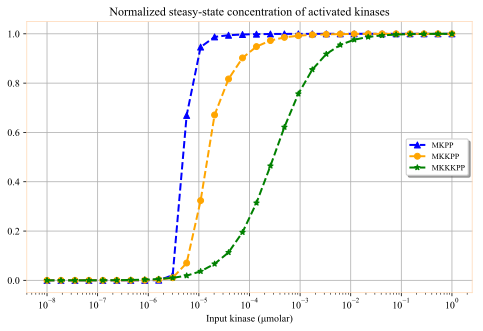

In [44]:
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = 'svg'

f = ticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = ticker.FuncFormatter(g)

f.set_scientific(True)
f.set_powerlimits((-1,1)) 

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=9)

mpl.rc('font',family='Times New Roman')
rcParams['figure.figsize'] = 8, 5


MKKKP_ss_max = max(MKKKP_ss)
MKKPP_ss_max = max(MKKPP_ss)
MKPP_ss_max = max(MKPP_ss)


SS=[MKPP_ss, MKKPP_ss, MKKKP_ss]
SS_max=[MKPP_ss_max, MKKPP_ss_max, MKKKP_ss_max]

fig, ax = plt.subplots()

i=0

ax = plt.axes(xscale='log')

for c,l,m in zip(['blue', 'orange', 'green'],['MKPP', 'MKKPP', 'MKKKPP'],['^','o','*']):

    ax.plot([clamp for clamp in clamps], SS[i]/SS_max[i] , color=c, label=l, marker=m ,markevery=1,ms=6,linestyle='--',linewidth=2)
    i+=1
    
# plt.axvline(x=30.575865759626872e-3, color='r', linestyle='--', label='steady input: 0.0305')
plt.title('Normalized steasy-state concentration of activated kinases')    
plt.xlabel('Input kinase ($\mathregular{\mu molar}$)')
plt.legend(loc = 'center right',shadow=True, fontsize='8')
plt.grid()


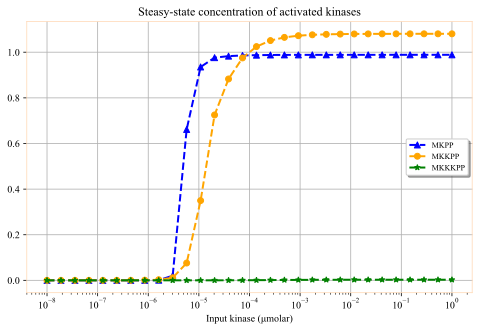

In [45]:
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = 'svg'

f = ticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = ticker.FuncFormatter(g)

f.set_scientific(True)
f.set_powerlimits((-1,1)) 

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=9)

mpl.rc('font',family='Times New Roman')
rcParams['figure.figsize'] = 8, 5


MKKKP_ss_max = max(MKKKP_ss)
MKKPP_ss_max = max(MKKPP_ss)
MKPP_ss_max = max(MKPP_ss)


SS=[MKPP_ss, MKKPP_ss, MKKKP_ss]
SS_max=[MKPP_ss_max, MKKPP_ss_max, MKKKP_ss_max]

fig, ax = plt.subplots()

i=0

ax = plt.axes(xscale='log')

for c,l,m in zip(['blue', 'orange', 'green'],['MKPP', 'MKKPP', 'MKKKPP'],['^','o','*']):

    ax.plot([clamp for clamp in clamps], SS[i], color=c, label=l, marker=m ,markevery=1,ms=6,linestyle='--',linewidth=2)
    i+=1
    
# plt.axvline(x=30.575865759626872e-3, color='r', linestyle='--', label='steady input: 0.0305')
plt.title('Steasy-state concentration of activated kinases')    
plt.xlabel('Input kinase ($\mathregular{\mu molar}$)')
plt.legend(loc = 'center right',shadow=True, fontsize='8')
plt.grid()


In [34]:
# x_0['x_0'] = 3e-5
t_span = [0,100]
t, x = bgt.simulate(model, timespan=t_span, control_vars={}, x0=x_0, dt=0.1)

In [ ]:
## To plot the simulation results, check the annotation and number of the state variables using model.state_vars
## The order of the state variables changes if you change the order of inserting the CellML files.
## Make sure you are selecting the correct state variable by observing their annotations in model.state_vars

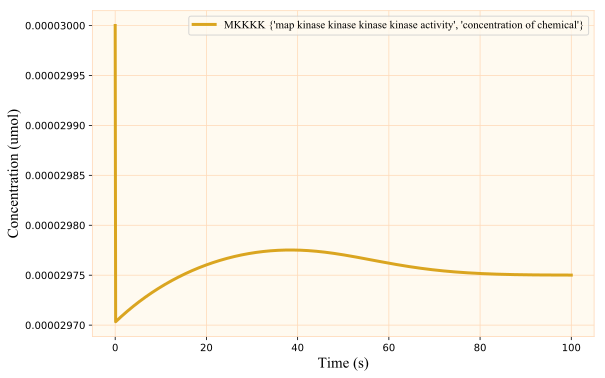

In [35]:
%config InlineBackend.figure_format = 'svg'

rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.rc('axes',edgecolor='peachpuff')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,0],'goldenrod', linewidth='3', label='MKKKK'+' '+str(list(model.state_vars.values())[0][0].name))
plt.legend(bbox_to_anchor=(1, 1), prop=font )

plt.grid(color='peachpuff')
plt.xlabel('Time (s)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (umol)', fontweight='bold',family='Times New Roman', fontsize=15)

plt.savefig('mkkkk.svg')

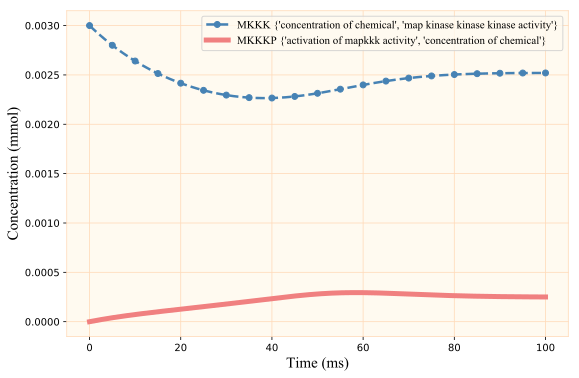

In [36]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,4],'steelblue',marker= 'o',markevery=50,ms=6,linestyle='--',linewidth=2.5, label='MKKK'+' '+str(list(model.state_vars.values())[4][0].name))
plt.plot(t,x[:,5],'lightcoral', linewidth=5, label='MKKKP'+' '+str(list(model.state_vars.values())[5][0].name))
plt.legend(bbox_to_anchor=(1, 1), fontsize=8, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (mmol)', fontweight='bold',family='Times New Roman', fontsize=15)

plt.savefig('mkkk_mkkkp.svg')

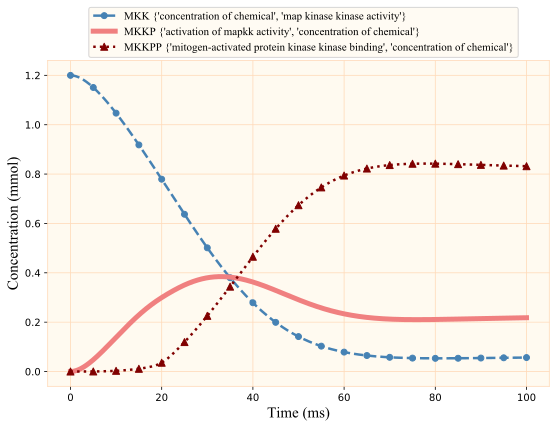

In [37]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,12],'steelblue',marker= 'o',markevery=50,ms=6,linestyle='--',linewidth=2.5,label='MKK'+' '+str(list(model.state_vars.values())[12][0].name))
plt.plot(t,x[:,13],'lightcoral',linewidth=5 ,label='MKKP'+' '+str(list(model.state_vars.values())[13][0].name))
plt.plot(t,x[:,16],'maroon',marker= '^',markevery=50,ms=7,linestyle=':',linewidth=2.5, label='MKKPP'+' '+str(list(model.state_vars.values())[16][0].name))
plt.legend(loc='upper center',bbox_to_anchor=(0.51, 1.18), fontsize=8, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (mmol)', fontweight='bold',family='Times New Roman', fontsize=15)

plt.savefig('mkk_mkkp_mkkpp.svg')

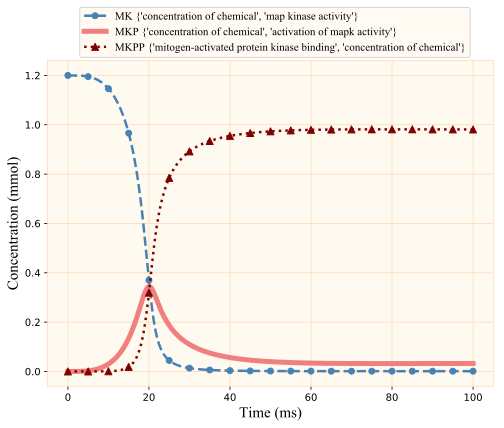

In [38]:
rcParams['figure.figsize'] = 8, 6
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,20],'steelblue',marker= 'o',markevery=50,ms=6,linewidth=2.5, linestyle='--', label='MK'+' '+str(list(model.state_vars.values())[20][0].name))
plt.plot(t,x[:,21],'lightcoral', linewidth='5', label='MKP'+' '+str(list(model.state_vars.values())[21][0].name))
plt.plot(t,x[:,24],'maroon',marker= '^',markevery=50,ms=7,linestyle=':',linewidth=2.5, label='MKPP'+' '+str(list(model.state_vars.values())[24][0].name))
plt.legend(loc='upper center',bbox_to_anchor=(0.51, 1.18), fontsize=8, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel('Concentration (mmol)', fontweight='bold',family='Times New Roman', fontsize=15)

plt.savefig('mk_mkp_mkpp.svg')

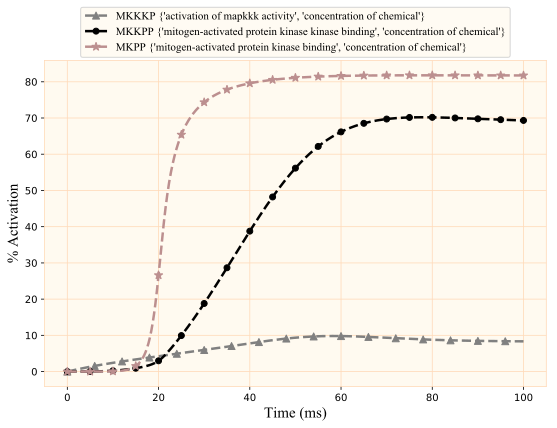

In [39]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'floralwhite'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,100*x[:,5]/x[0,4],'grey',marker= '^',markevery=60,ms=7,linestyle='--',linewidth=2.5, label='MKKKP'+' '+str(list(model.state_vars.values())[5][0].name))
plt.plot(t,100*x[:,16]/x[0,12],'k',marker= 'o',markevery=50,ms=6,linestyle='--',linewidth=2.5,label='MKKPP'+' '+str(list(model.state_vars.values())[16][0].name))
plt.plot(t,100*x[:,24]/x[0,20],'rosybrown',marker= '*',markevery=50,ms=9, linestyle='--',linewidth=2.5, label='MKPP'+' '+str(list(model.state_vars.values())[24][0].name))

plt.legend(loc='upper center',bbox_to_anchor=(0.50, 1.18), fontsize=9, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel("% Activation", fontweight='bold',family='Times New Roman', fontsize=15)

plt.savefig('activation.svg')

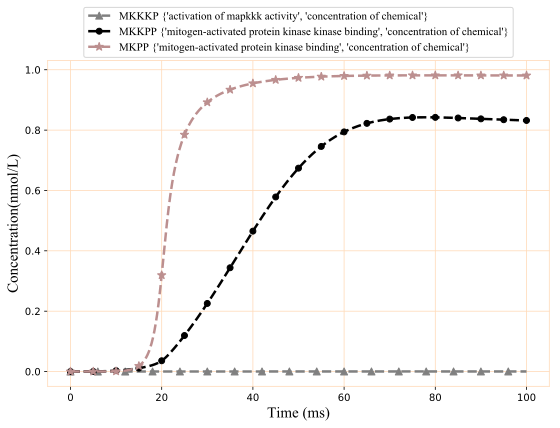

In [40]:
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='peachpuff')
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)

plt.plot(t,x[:,5],'grey',marker= '^',markevery=60,ms=7,linestyle='--',linewidth=2.5, label='MKKKP'+' '+str(list(model.state_vars.values())[5][0].name))
plt.plot(t,x[:,16],'k',marker= 'o',markevery=50,ms=6,linestyle='--',linewidth=2.5,label='MKKPP'+' '+str(list(model.state_vars.values())[16][0].name))
plt.plot(t,x[:,24],'rosybrown',marker= '*',markevery=50,ms=9, linestyle='--',linewidth=2.5, label='MKPP'+' '+str(list(model.state_vars.values())[24][0].name))

plt.legend(loc='upper center',bbox_to_anchor=(0.50, 1.18), fontsize=9, prop=font)
plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.ylabel("Concentration(nmol/L)", fontweight='bold',family='Times New Roman', fontsize=15)

plt.savefig('kinases.svg')

In [41]:
np.savetxt("michael_MKKKK.csv", x[:,0], delimiter=",")   #MKKKK
np.savetxt("michael_MKKK.csv", x[:,4], delimiter=",")   #MKKK
np.savetxt("michael_MKKKP.csv", x[:,5], delimiter=",")   #MKKKP

np.savetxt("michael_MKK.csv", x[:,12], delimiter=",")   #MKK
np.savetxt("michael_MKKP.csv", x[:,13], delimiter=",")   #MKKP
np.savetxt("michael_MKKPP.csv", x[:,16], delimiter=",")   #MKKPP

np.savetxt("michael_MK.csv", x[:,20], delimiter=",")   #MK
np.savetxt("michael_MKP.csv", x[:,21], delimiter=",")   #MKP
np.savetxt("michael_MKPP.csv", x[:,24], delimiter=",")   #MKPP